In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
#dataset load
drebin_all = pd.read_csv('drebin-215-dataset-5560malware-9476-benign.csv', 
                         usecols= [*range(0, 6),*range(7, 13),*range(14,19)
                                  ,21,23,24,*range(28,38),41,43,46,48,51,54,
                                   57,58,59,62,64,68,70,78,80,*range(83,87),
                                   *range(92, 95),98,101,102,104,109,123,128,
                                   140,142,145,147,148,152,155,156,158,167,
                                   171,172,180,190,215])

/home/galib/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#drebin_all.info()
X = drebin_all.iloc[0:,0:73]  #independent columns
y = drebin_all.iloc[0:,-1]
X["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [5]:
y = y.map(dict(S=1, B=0))

In [6]:
y[1]

1

In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [11]:
#mandatory import 
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


from sklearn.feature_selection import RFE

In [7]:
pre = []
rec = []
fs = []
acc = []
auc = []
def clear_metrics(): 
    pre.clear()
    rec.clear()
    fs.clear()
    acc.clear()
    auc.clear()

In [160]:
def allscore(scores,i):
    acc.insert(i,scores['test_accuracy'].mean())
    fs.insert(i,scores['test_f1'].mean())
    pre.insert(i,scores['test_precision'].mean())
    rec.insert(i,scores['test_recall'].mean())
    auc.insert(i,scores['test_roc_auc'].mean())
    print("Accuracy: %0.4f   (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("Precision: %0.4f   (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_accuracy'].std() * 2))
    print("Recall: %0.4f   (+/- %0.4f)" % (scores['test_recall'].mean(), scores['test_accuracy'].std() * 2))
    print("F-1 Score: %0.4f   (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_accuracy'].std() * 2))
    print("ROC-AUC: %0.4f   (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_accuracy'].std() * 2))
def run_randomForest(X,y, i=0):
    scoring = ['precision', 'recall', 'f1','accuracy','roc_auc']
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=2,
                        scoring=scoring, return_train_score=False)
    print('Classification Report for Random Forest:   ', i)
    allscore(scores,i)
def incremental_plot(i,j,title, x_axis = "Number of Features"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = pre
    y2 = rec
    y3 = acc
    y4 = fs

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Performance Metrics")
    ax.plot(x,y1, marker = 'v', mew = 1, label='Precision') #mew = marker width
    ax.plot(x,y2, marker = '^', mew = 1, label='Recall') #mew = marker width
    ax.plot(x,y3, marker = 'o', mew = 1, label='Accuracy') #mew = marker width
    ax.plot(x,y4, marker = 's', mew = 1, label='F-1 Score') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    plt.savefig(title + '.png', bbox_inches='tight', pad_inches=.1)
    

In [118]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=35)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['APIs','Score']  #naming the dataframe columns

In [134]:
#sorted_features = featureScores.Score.sort_values(ascending = False)                    
feat_scores = pd.Series(featureScores.Score, index=X_train.columns)
sorted_features = pd.Series(feat_scores.sort_values(ascending = False))                       
X_col = X
X_col.shape
sorted_features.index[71]   


'findClass'

In [135]:
clear_metrics()
index=72
run_randomForest(X_col,y, index)

for index in range(73,0,-1):    
    if X_col.shape[1] > 1 :
        X_col = X_col.drop(labels = sorted_features.index[index-1], axis = 1)
        print(X_col.shape)
        run_randomForest(X_col,y, index-1)

Classification Report for Random Forest:    72
Accuracy: 0.9763   (+/- 0.0015)
Precision: 0.9840   (+/- 0.0015)
Recall: 0.9513   (+/- 0.0015)
F-1 Score: 0.9674   (+/- 0.0015)
ROC-AUC: 0.9942   (+/- 0.0015)
(15036, 72)
Classification Report for Random Forest:    72
Accuracy: 0.9760   (+/- 0.0004)
Precision: 0.9838   (+/- 0.0004)
Recall: 0.9507   (+/- 0.0004)
F-1 Score: 0.9670   (+/- 0.0004)
ROC-AUC: 0.9942   (+/- 0.0004)
(15036, 71)
Classification Report for Random Forest:    71
Accuracy: 0.9757   (+/- 0.0009)
Precision: 0.9809   (+/- 0.0009)
Recall: 0.9529   (+/- 0.0009)
F-1 Score: 0.9667   (+/- 0.0009)
ROC-AUC: 0.9944   (+/- 0.0009)
(15036, 70)
Classification Report for Random Forest:    70
Accuracy: 0.9759   (+/- 0.0004)
Precision: 0.9824   (+/- 0.0004)
Recall: 0.9518   (+/- 0.0004)
F-1 Score: 0.9668   (+/- 0.0004)
ROC-AUC: 0.9939   (+/- 0.0004)
(15036, 69)
Classification Report for Random Forest:    69
Accuracy: 0.9750   (+/- 0.0000)
Precision: 0.9795   (+/- 0.0000)
Recall: 0.9523  

Classification Report for Random Forest:    35
Accuracy: 0.9596   (+/- 0.0044)
Precision: 0.9665   (+/- 0.0044)
Recall: 0.9228   (+/- 0.0044)
F-1 Score: 0.9442   (+/- 0.0044)
ROC-AUC: 0.9899   (+/- 0.0044)
(15036, 34)
Classification Report for Random Forest:    34
Accuracy: 0.9610   (+/- 0.0036)
Precision: 0.9654   (+/- 0.0036)
Recall: 0.9277   (+/- 0.0036)
F-1 Score: 0.9462   (+/- 0.0036)
ROC-AUC: 0.9898   (+/- 0.0036)
(15036, 33)
Classification Report for Random Forest:    33
Accuracy: 0.9594   (+/- 0.0040)
Precision: 0.9674   (+/- 0.0040)
Recall: 0.9214   (+/- 0.0040)
F-1 Score: 0.9438   (+/- 0.0040)
ROC-AUC: 0.9890   (+/- 0.0040)
(15036, 32)
Classification Report for Random Forest:    32
Accuracy: 0.9546   (+/- 0.0005)
Precision: 0.9563   (+/- 0.0005)
Recall: 0.9194   (+/- 0.0005)
F-1 Score: 0.9375   (+/- 0.0005)
ROC-AUC: 0.9880   (+/- 0.0005)
(15036, 31)
Classification Report for Random Forest:    31
Accuracy: 0.9497   (+/- 0.0009)
Precision: 0.9486   (+/- 0.0009)
Recall: 0.9135  

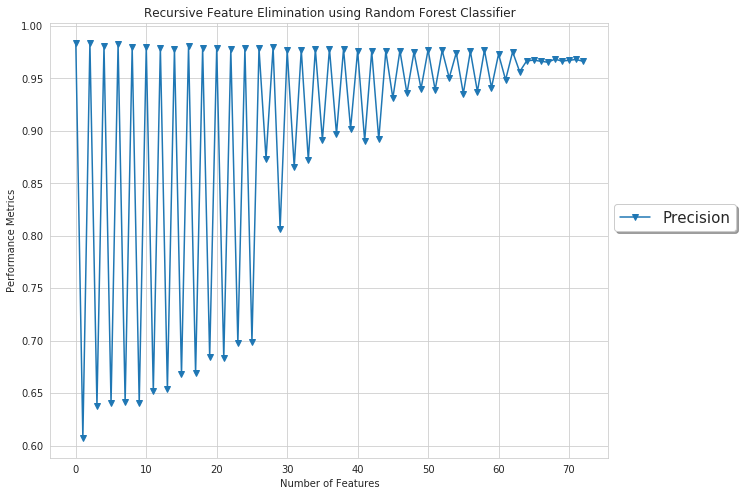

In [138]:
incremental_plot(0,73,"Recursive Feature Elimination using Random Forest Classifier")

## Feature Importance (feature_importances_)

In [18]:
for index in range(3,0,-1):     
    print (index-1)

2
1
0


In [109]:
#best ForestClassifier Parameter for feature importances 
clear_metrics()
model = ExtraTreesClassifier(random_state=2)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
sorted_features = pd.Series(feat_importances.sort_values(ascending = False))                       
X_col = X
X_col.shape
sorted_features.index[0]   

/home/galib/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


'transact'

In [89]:
X_feature.shape

(15036, 0)

In [103]:
clear_metrics()
index=73
run_randomForest(X_col,y, index)

for index in range(73,0,-1):    
    if X_col.shape[1] > 1 :
        X_col = X_col.drop(labels = sorted_features.index[index-1], axis = 1)
        print(X_col.shape)
        run_randomForest(X_col,y, index-1)
   

Classification Report for Random Forest:    73
Accuracy: 0.9763   (+/- 0.0015)
Precision: 0.9840   (+/- 0.0015)
Recall: 0.9513   (+/- 0.0015)
F-1 Score: 0.9674   (+/- 0.0015)
ROC-AUC: 0.9942   (+/- 0.0015)
(15036, 70)
Classification Report for Random Forest:    72
Accuracy: 0.9768   (+/- 0.0012)
Precision: 0.9829   (+/- 0.0012)
Recall: 0.9538   (+/- 0.0012)
F-1 Score: 0.9681   (+/- 0.0012)
ROC-AUC: 0.9942   (+/- 0.0012)
(15036, 67)
Classification Report for Random Forest:    69
Accuracy: 0.9761   (+/- 0.0028)
Precision: 0.9818   (+/- 0.0028)
Recall: 0.9531   (+/- 0.0028)
F-1 Score: 0.9672   (+/- 0.0028)
ROC-AUC: 0.9942   (+/- 0.0028)
(15036, 64)
Classification Report for Random Forest:    66
Accuracy: 0.9757   (+/- 0.0029)
Precision: 0.9827   (+/- 0.0029)
Recall: 0.9509   (+/- 0.0029)
F-1 Score: 0.9665   (+/- 0.0029)
ROC-AUC: 0.9940   (+/- 0.0029)
(15036, 61)
Classification Report for Random Forest:    63
Accuracy: 0.9762   (+/- 0.0016)
Precision: 0.9824   (+/- 0.0016)
Recall: 0.9527  

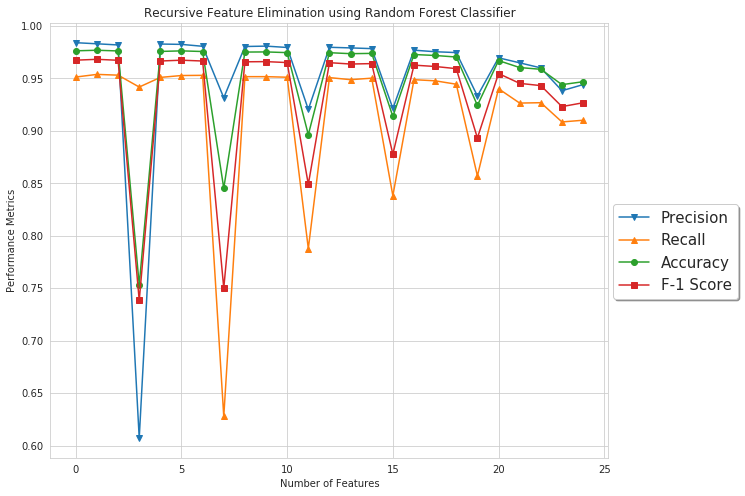

In [106]:
incremental_plot(0,25,"Recursive Feature Elimination using Random Forest Classifier")

## Feature Selection Based on Mutual Information (Entropy) Gain

In [140]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

In [151]:
mi = mutual_info_classif(X_train, y_train)
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


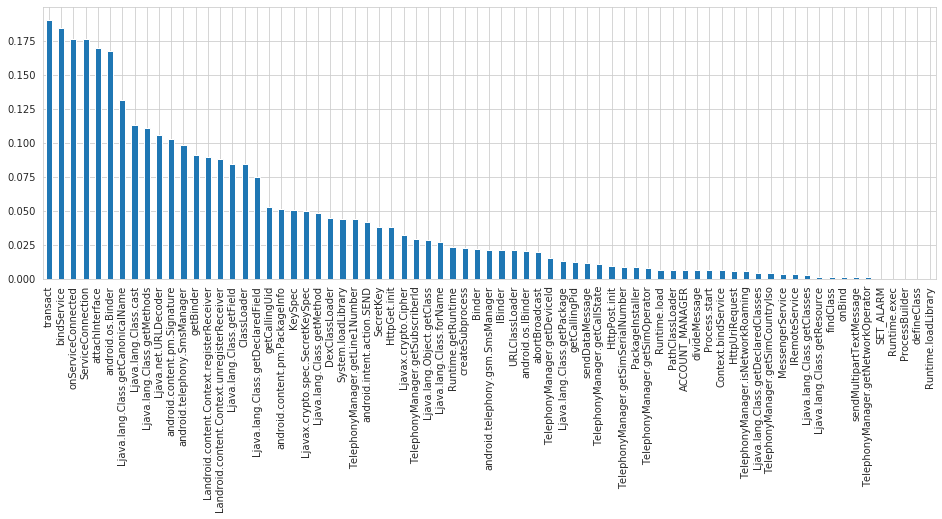

In [152]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
mi.plot.bar(figsize = (16,5))

In [164]:
clear_metrics()
for index in range(5, 100,20):
    sel = SelectPercentile(mutual_info_classif, percentile=index).fit(X_train, y_train)
    #X_train.columns[sel.get_support()]
    X_mutual_info = sel.transform(X)
    print("Features Considered:")
    print(X_mutual_info.shape[1])
    run_randomForest(X_mutual_info, y, round(index*100/72))

Features Considered:
4
Classification Report for Random Forest:    7
Accuracy: 0.7755   (+/- 0.0028)
Precision: 0.6416   (+/- 0.0028)
Recall: 0.8905   (+/- 0.0028)
F-1 Score: 0.7458   (+/- 0.0028)
ROC-AUC: 0.8214   (+/- 0.0028)
Features Considered:
18
Classification Report for Random Forest:    35
Accuracy: 0.8629   (+/- 0.0029)
Precision: 0.8915   (+/- 0.0029)
Recall: 0.7164   (+/- 0.0029)
F-1 Score: 0.7944   (+/- 0.0029)
ROC-AUC: 0.9484   (+/- 0.0029)
Features Considered:
33
Classification Report for Random Forest:    62
Accuracy: 0.9562   (+/- 0.0011)
Precision: 0.9572   (+/- 0.0011)
Recall: 0.9230   (+/- 0.0011)
F-1 Score: 0.9397   (+/- 0.0011)
ROC-AUC: 0.9890   (+/- 0.0011)
Features Considered:
47
Classification Report for Random Forest:    90
Accuracy: 0.9721   (+/- 0.0019)
Precision: 0.9768   (+/- 0.0019)
Recall: 0.9469   (+/- 0.0019)
F-1 Score: 0.9616   (+/- 0.0019)
ROC-AUC: 0.9928   (+/- 0.0019)
Features Considered:
62
Classification Report for Random Forest:    118
Accuracy: 

ValueError: x and y must have same first dimension, but have shapes (475,) and (19,)

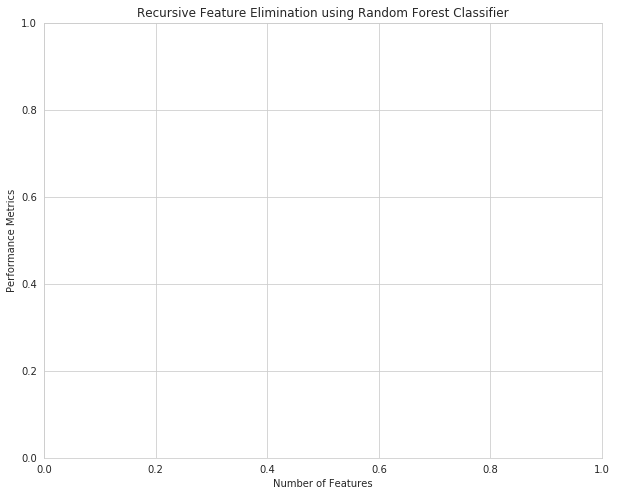

In [163]:
incremental_plot(0,62,"Recursive Feature Elimination using Random Forest Classifier")

In [13]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(29, 31):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select = index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X)
    print('Selected Feature: ', index)
    run_randomForest(X_transform, y, index)

Selected Feature:  29
Classification Report for Random Forest:    29
Accuracy: 0.9724   (+/- 0.0089)
Precision: 0.9733   (+/- 0.0089)
Recall: 0.9514   (+/- 0.0089)
F-1 Score: 0.9622   (+/- 0.0089)
ROC-AUC: 0.9937   (+/- 0.0089)
Selected Feature:  30
Classification Report for Random Forest:    30
Accuracy: 0.9730   (+/- 0.0088)
Precision: 0.9751   (+/- 0.0088)
Recall: 0.9513   (+/- 0.0088)
F-1 Score: 0.9630   (+/- 0.0088)
ROC-AUC: 0.9938   (+/- 0.0088)


In [41]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(1, 3):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select = index)
    sel.fit(X_train, y_train)
    X_train_optimal = sel.transform(X_train)
    X_test_optimal = sel.transform(X_test)
    print('Selected Feature: ', index)
    run_randomForest(X_train_optimal, X_test_optimal, y_train, y_test, index)

Selected Feature:  1
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9622    0.6423    0.7703      1940
           1     0.5949    0.9541    0.7328      1068

    accuracy                         0.7530      3008
   macro avg     0.7785    0.7982    0.7516      3008
weighted avg     0.8318    0.7530    0.7570      3008

Selected Feature:  2
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.7485    0.9943    0.8541      1940
           1     0.9745    0.3933    0.5604      1068

    accuracy                         0.7809      3008
   macro avg     0.8615    0.6938    0.7072      3008
weighted avg     0.8288    0.7809    0.7498      3008



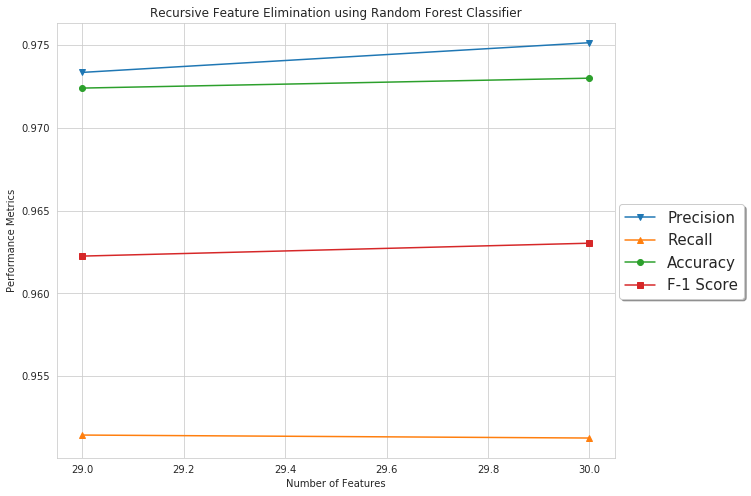

In [14]:
incremental_plot(29,31,"Recursive Feature Elimination using Random Forest Classifier")

In [ ]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(1, 36):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select = index)
    sel.fit(X_train, y_train)
    X_train_optimal = sel.transform(X_train)
    X_test_optimal = sel.transform(X_test)
    print('Selected Feature: ', index)
    run_randomForest(X_train_optimal, X_test_optimal, y_train, y_test, index)

In [ ]:
#best RFE(radient BoostingClassifier) features
clear_metrics()
for index in range(1, 36):
    sel = RFE(RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1), n_features_to_select = index)
    sel.fit(X_train, y_train)
    X_train_optimal = sel.transform(X_train)
    X_test_optimal = sel.transform(X_test)
    print('Selected Feature: ', index)
    run_randomForest(X_train_optimal, X_test_optimal, y_train, y_test, index)